<a href="https://colab.research.google.com/github/CP2J/cp2j/blob/ACJ-11-opt1-RecSys_by_DL/RecSys_with_DL(occu%2C%20age).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝을 사용한 추천 시스템 - 변수추가
* User, Item을 embedding해서 입력으로 넣으면 사용자와 아이템 간의 특성을 학습해서 추천(예측)에 이용할 수 있다.
* 딥러닝 신경망은 필요하면 다양한 변수(사용자와 아이템의 features)를 추가할 수 있다.
* 사용자의 직업에 따라 영화를 평가하는 패턴이 다르다는 가정을 한다면, 직업을 모델에서 고려하는 경우 예측이 더 정확해질 것이다.

    < Reference : Python을 이용한 개인화 추천 시스템 2판 >

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

# csv 파일에서 불러오기
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/ml-100k/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거, 정수형 변환

In [ ]:
# Train-test 분리 (이렇게 나누는 방법도 있군)
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75                         # 0.75 : 0.25
ratings = shuffle(ratings)                # row를 섞는다.
cutoff = int(TRAIN_SIZE * len(ratings))   # 끊는 지점
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [ ]:
# 수정된 부분 1 >>>>>>>>>>
# 사용자 데이터를 읽어와 id와 나이, 직업만 남긴다.
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('/content/drive/MyDrive/ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')
users = users[['user_id', 'age', 'occupation']]

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   occupation  943 non-null    object
dtypes: int64(2), object(1)
memory usage: 22.2+ KB


In [ ]:
# Convert occupation(string to integer)
occupation = {}
# occupation을 string -> int 형식으로 mapping 할 dict 선언
def convert_occ(x):
# occupation(string)이 입력되면 -> int를 mapping 해서 저장
    if x in occupation:
        return occupation[x]
    # 만일 현재 occupation에 대응하는 int값이 dict 에 존재하면, 해당 값을 반환
    else:
    # 만일 현재 occupation에 대응하는 int값이 dict 에 존재하지 않으면,
        occupation[x] = len(occupation)
        # 새로운 element를 새로운 int와 같이 dict 에 추가한다.
        return occupation[x]
        # 새로운 int 값을 반환한다.
users['occupation'] = users['occupation'].apply(convert_occ)
# 사용자 데이터의 'occupation' 컬럼을 int로 변환

L = len(occupation)
# occupation의 unique 값 개수를 저장(추후 embedding에 사용)
A = users['age'].nunique()
# age의 unique 값 개수를 저장

train_users = pd.merge(ratings_train, users, on = 'user_id')
# train set과 사용자 데이터를 merge. 딥러닝의 입력으로 사용자의 모든 user_id에 대해 age와 occupation 필요하다. 
test_users = pd.merge(ratings_test, users, on = 'user_id')
# test도 merge
#<<<<<<<<< 수정된 부분 1

In [ ]:
train_users

,user_id,movie_id,rating,age,occupation
0,807,79,5,41,17
1,807,511,5,41,17
2,807,210,4,41,17
3,807,843,2,41,17
4,807,151,4,41,17
...,...,...,...,...,...
74995,88,1191,5,49,11
74996,88,311,5,49,11
74997,88,315,4,49,11
74998,88,319,3,49,11


In [ ]:
occupation           # 20개의 직업을 int에 대응시킨 dict

{'technician': 0,
 'other': 1,
 'writer': 2,
 'executive': 3,
 'administrator': 4,
 'student': 5,
 'lawyer': 6,
 'educator': 7,
 'scientist': 8,
 'entertainment': 9,
 'programmer': 10,
 'librarian': 11,
 'homemaker': 12,
 'artist': 13,
 'engineer': 14,
 'marketing': 15,
 'none': 16,
 'healthcare': 17,
 'retired': 18,
 'salesman': 19,
 'doctor': 20}

In [ ]:
users['age'].unique()

array([24, 53, 23, 33, 42, 57, 36, 29, 39, 28, 47, 45, 49, 21, 30, 35, 40,
       26, 25, 32, 41,  7, 38, 20, 19, 27, 18, 22, 37, 16, 50, 31, 51, 17,
       48, 34, 43, 60, 55, 15, 61, 44, 54, 59, 46, 13, 52, 56, 14, 66, 62,
       11, 65, 68, 63, 64, 10, 73, 58, 69, 70])

In [ ]:
A

61

In [ ]:
##### (1)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

In [ ]:
ratings.describe()

,user_id,movie_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


In [ ]:
# Variable 초기화
K = 200                               # Latent factor(잠재요인) 수
mu = ratings_train.rating.mean()      # 전체 평균
M = ratings.user_id.max() +1          # 사용자 아이디 최대값+1 : Number of users로 간주, 추후 Embedding에 사용
# 사용자 아이디는 1부터 943이지만(위 describe 참고)
# adding 1 ensures that all user IDs from 0 to the maximum ID are included in the embedding layer.
N = ratings.movie_id.max() +1         # Number of movies

# RMSE 정의
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

<img src="https://drive.google.com/uc?id=1sdPLEYtb9eJ50DwhAS-yDjlYRW7eHraf" alt="딥러닝 신경망 모델" height="300" width="400">

In [ ]:
##### (2)
# Keras model
user = Input(shape=(1, ))                                             # 사용자 데이터 입력 형식 지정(id만 받음)
item = Input(shape=(1, ))                                             # 아이템 데이터 입력 형식 지정(id만 받음)
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)      # 사용자 Embedding layer 지정 (M, 1, K) : (M X K)의 연결을 가진다.
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)      # 아이템 Embedding layer 지정 (N, 1, K) : (N X K)의 연결을 가진다.
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)        # User bias term (M, 1, ) : (M X 1)의 연결
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)        # Item bias term (N, 1, ) : (N X 1)의 연결

# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation    # 나중에 layer 구성에서 사용할 메소드 로드
P_embedding = Flatten()(P_embedding)          # (K, )
Q_embedding = Flatten()(Q_embedding)          # (K, )
user_bias = Flatten()(user_bias)              # (1, )
item_bias = Flatten()(item_bias)              # (1, )
# Concatenate() 위해서 1차원으로 줄인다.

# 수정된 부분 2 >>>>>>>>>>
occ = Input(shape=(1, ))                                                          # occupation에 대한 입력을 새로 만든다.
occ_embedding = Embedding(L, 3, embeddings_regularizer=l2())(occ)                 # occupation을 3개의 잠재요인으로 embedding한다. (K=3)
occ_layer = Flatten()(occ_embedding)                                              # 합치기 위해 차원 줄이기
age = Input(shape=(1, ))                                                          # age 에 대한 입력을 새로 만든다.
age_layer = Dense(1)(age)                                                         # age 입력은 Dense layer 통과후 Concatenate

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, occ_layer, age_layer])    # (2K+2+3+1, )
# P, Q, 사용자 bias, 아이템 bias, occupation, age 까지 6개의 layer 붙여서 하나의 layer를 만든다.
#<<<<<<<<< 수정된 부분 2

# Neural network
R = Dense(2048)(R)              # 노드가 2048개인 dense layer 추가
R = Activation('relu')(R)       # 이 layer의 activation 함수 : 'relu'
R = Dense(256)(R)               # 노드가 256개인 dense layer 하나 더 추가
R = Activation('linear')(R)     # 이 layer의 activation 함수 : 'linear'
R = Dense(1)(R)                 # 노드가 1개인 dense layer를 하나 더 추가 한다. 이 layer가 출력에 연결된다.

# 수정된 부분 3 >>>>>>>>>>
# Model setting : 위의 신경망과 입력을 연결해서 모델을 구성한다.
model = Model(inputs = [user, item, occ, age], outputs = R)
#<<<<<<<<< 수정된 부분 3
model.compile(
    loss = RMSE,                # loss함수
    optimizer = SGD(),
    #optimizer = Adamax(),
    metrics = [RMSE]            # 측정지표
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 1, 200)       188800      ['input_9[0][0]']                
                                                                                            

* input layer 2개가 각각 embedding layer에 연결된다.
* 사용자 수를 944(943+1)로 잡았기 때문에 200개의 잠재요인 layer(embedding)에 연결되는 파라미터의 수는 188,800(944 x 200)이 되고,
* 아이템의 수는 1683(1682+1)개 이므로 200개의 잠재요인 layer(embedding_1)에 연결되는 파라미터의 수는 336,600(1683 x 200)이 된다.
* 사용자 bias layer(embedding_2)는 944개, 아이템 bias layer(embedding_3)는 1683개의 파라미터를 갖는다.


* input_3 : Occupation
Occupation은 20개이고, 3개의 잠재요인 layer(embedding_4)에 연결되는 파라미터의 수는 63(20*3 + 3)개이다.


* input_4 : Age
* 이 6개의 embedding layer는 합쳐져서 하나의 layer(Concatenate)가 되고, 이 layer의 노드 수는 406개
(사용자 임베딩 200 + 아이템 임베딩 200 + 사용자 bias 1 + 아이템 bias 1 + 직업 임베딩 3 + Age 1)
* 다음으로 2048개의 노드를 갖는 Dense layer(dense)에 연결 : 이때 연결 파라미터 수는 833536((406+1) x 2048)개가 된다.
* 다음으로 256개의 노드를 갖는 Dense layer(dense_1)에 연결 : 이때 연결 파라미터 수는 524544((2048+1) x 256)개가 된다.
* 위 layer는 노드가 1개인 최종 layer(dense_2)에 연결되고 파라미터의 수는 257개가 된다.


총 파라미터의 수는 이들을 모두 합한 **1,886,427개**가 된다.

In [ ]:
# Model fitting (위에서 구성한 신경망을 학습시킨다)
result = model.fit(
    x = [ratings_train.user_id.values, ratings_train.movie_id.values, train_users.occupation.values, train_users.age.values],
    # 입력(독립변수)은 train set의 사용자, 아이템 id, occupation id
    y = ratings_train.rating.values - mu,
    # 출력(종속변수)은 평점에서 전체평균을 뺀 것으로 지정
    epochs = 65,              # 반복횟수
    batch_size = 512,         # 한번에 학습(연산)하는 batch 크기를 지정
    validation_data = (
      [ratings_test.user_id.values, ratings_test.movie_id.values, test_users.occupation.values, test_users.age.values],  # 검증을 위한 입력
      ratings_test.rating.values - mu                               # 검증에 쓰이는 출력
    )
)

Epoch 1/65
147/147 [==============================] - 2s 8ms/step - loss: 5.6245 - RMSE: 1.3543 - val_loss: 5.2649 - val_RMSE: 1.1211
Epoch 2/65
147/147 [==============================] - 1s 5ms/step - loss: 5.1536 - RMSE: 1.1282 - val_loss: 5.0331 - val_RMSE: 1.1260
Epoch 3/65
147/147 [==============================] - 1s 6ms/step - loss: 4.9229 - RMSE: 1.1274 - val_loss: 4.8059 - val_RMSE: 1.1218
Epoch 4/65
147/147 [==============================] - 1s 6ms/step - loss: 4.7066 - RMSE: 1.1278 - val_loss: 4.5937 - val_RMSE: 1.1201
Epoch 5/65
147/147 [==============================] - 1s 6ms/step - loss: 4.5007 - RMSE: 1.1266 - val_loss: 4.3968 - val_RMSE: 1.1215
Epoch 6/65
147/147 [==============================] - 1s 8ms/step - loss: 4.3076 - RMSE: 1.1258 - val_loss: 4.2076 - val_RMSE: 1.1192
Epoch 7/65
147/147 [==============================] - 1s 9ms/step - loss: 4.1260 - RMSE: 1.1258 - val_loss: 4.0309 - val_RMSE: 1.1189
Epoch 8/65
147/147 [==============================] - 1s 7ms/s

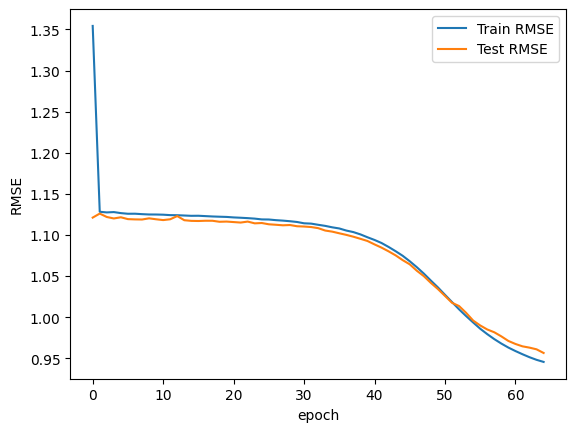

In [ ]:
# 학습과정에서 측정지표의 변화
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
# Prediction (학습을 마친 신경망으로 예측을 수행)
user_ids = ratings_test.user_id.values[0:6]
movie_ids= ratings_test.movie_id.values[0:6]                          # 예측 대상을 테스트셋 처음 6개로 정함
test_occ = test_users.occupation.values[0:6]
test_age = test_users.age.values[0:6]
predictions = model.predict([user_ids, movie_ids, test_occ, test_age]) + mu     # 예측치를 구한 후 학습시 빼준 전체평균을 다시 더해줌
print("Actuals: \n", ratings_test[0:6])
print( )
print("Predictions: \n", predictions)

1/1 [==============================] - 0s 100ms/step
Actuals: 
        user_id  movie_id  rating
14060        6       521       4
20175        1         9       5
79399      830       176       3
2690       151       429       5
88903      838       750       4
3312        22       687       1

Predictions: 
 [[3.5673556]
 [3.9187686]
 [4.06554  ]
 [4.2006693]
 [4.072749 ]
 [2.4339237]]


In [ ]:
# 신경망에서 예측한 결과의 실제 RMSE 계산
def RMSE2(y_true, y_pred):
    return np.sqrt( np.mean( ( np.array(y_true) - np.array(y_pred) )**2 ) )

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
test_occ = test_users.occupation.values
test_age = test_users.age.values

y_pred = model.predict([user_ids, movie_ids, test_occ, test_age]) + mu
# Keras의 Model 클래스에서 제공하는 predict() 메소드는 신경망에 입력을 넣어주면 해당 신경망을 적용한 예측값을 계산해준다.
y_pred = np.ravel(y_pred, order = 'C')
# predict()로 얻은 예측값은 2차원(N X 1)의 array로 되어있으므로 np.ravel을 사용, 1차원 array로 바꿔준다.
y_true = np.array(ratings_test.rating)
# 실제 평점값을 가져온다.
RMSE2(y_true, y_pred)

782/782 [==============================] - 2s 2ms/step


0.9568027986138535